<a href="https://colab.research.google.com/github/mdabdullahpotol/mdabdullahpotol/blob/main/single_molecule_FRET_analysis_using_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# Import necessary libraries
# These libraries are tools that we need to perform various tasks like data handling,
# mathematical operations, and machine learning.
import numpy as np  # NumPy is used for numerical operations
import pandas as pd  # Pandas is used for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib is used for plotting graphs and visualizations
from scipy.optimize import curve_fit  # SciPy's curve_fit is used for fitting a curve to data
from sklearn.model_selection import train_test_split  # Used for splitting the data into training and test sets
from sklearn.metrics import mean_squared_error  # Used to calculate the mean squared error
from keras.models import Sequential  # Sequential model from Keras for building neural networks
from keras.layers import Dense  # Dense layer type for neural networks
from keras.optimizers import Adam  # Adam optimizer for training neural networks
from scipy.signal import correlate  # Used for signal processing, like cross-correlation
from scipy.fft import fft, ifft  # FFT (Fast Fourier Transform) for frequency analysis
from skimage.restoration import richardson_lucy, denoise_wavelet  # Image restoration tools

# Ensure that PyWavelets is installed for wavelet transforms
!pip install pywavelets  # This command installs the PyWavelets library if it's not already installed

import pywt  # Importing the PyWavelets library for wavelet transformations


In [35]:

# Load and clean data
# Here, we define a function to load data from a CSV file and clean it.
# Functions are reusable pieces of code that perform a specific task.

def load_and_clean_data(filename):
    """
    This function loads the data from a CSV file, checks for missing values,
    and cleans the data by interpolating or filling in those missing values.

    Parameters:
    filename (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The cleaned data.
    """
    try:
        # Read data from CSV file
        data = pd.read_csv(filename)

        # Check for missing values and handle them
        if data.isnull().values.any():
            # Interpolate missing values
            data.interpolate(method='linear', inplace=True)
            # Forward fill missing values
            data.ffill(inplace=True)
            # Backward fill missing values
            data.bfill(inplace=True)
            # Drop any remaining rows with missing values
            if data.isnull().values.any():
                data.dropna(inplace=True)
            # Raise an error if there are still missing values
            if data.isnull().values.any():
                raise ValueError("Unable to clean all missing values through interpolation or filling.")

        return data

    except FileNotFoundError:
        raise FileNotFoundError(f"File {filename} not found.")
    except Exception as e:
        raise Exception(f"An error occurred: {e}")

# Load FRET data
# FRET stands for Fluorescence Resonance Energy Transfer, which is a mechanism used to study interactions between two light-sensitive molecules.

data = load_and_clean_data('T2 pH 5.5 Ensemble Run 1.csv')
print(data.head())

   ID  Frame index  Groups  Donor Photons  Acceptor Photons  FRET efficiency  \
0   0            0     1.0        1181.67           363.567         0.235282   
1   0            1     1.0           0.00             0.000         0.000000   
2   0            2     1.0           0.00             0.000         0.000000   
3   0            3     1.0           0.00             0.000         0.000000   
4   0            4     1.0           0.00             0.000         0.000000   

    X (nm)   Y (nm)  
0  37667.1  20354.7  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0  


In [36]:

# Validate expected columns
# We need to ensure that the necessary columns are present in the data.
expected_columns = ['Frame index', 'FRET efficiency', 'Donor Photons', 'Acceptor Photons']
if not all(col in data.columns for col in expected_columns):
    raise ValueError(f"Expected columns {expected_columns} not found in the data. Found columns: {data.columns.tolist()}")

# Extract necessary data columns into variables
# Variables are like containers that store values. Here, we extract values from specific columns of the DataFrame.
frame_index = data['Frame index'].values
fret_efficiency = data['FRET efficiency'].values
donor_photons = data['Donor Photons'].values
acceptor_photons = data['Acceptor Photons'].values

# Photon count simulation using Poisson distribution
# Poisson distribution is often used to model random events. Here, we're simulating photon counts.
simulated_donor_photons = np.random.poisson(donor_photons)
simulated_acceptor_photons = np.random.poisson(acceptor_photons).astype(float)  # Convert to float

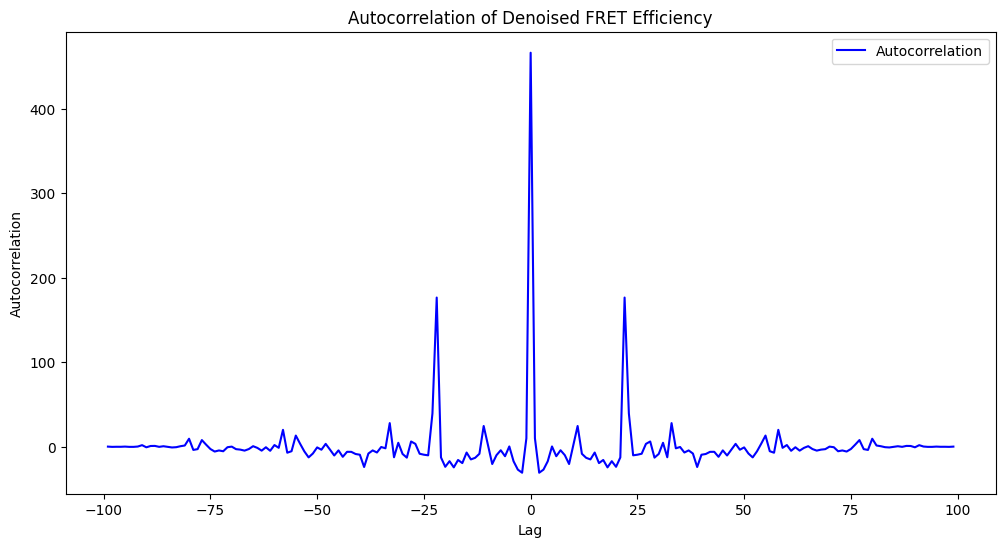

In [57]:

import numpy as np
from scipy.signal import correlate
from skimage.restoration import denoise_wavelet

# ================================
# Correction and Noise Reduction
# ================================

# Define Correction Factors
# These factors account for systematic errors in the measurement process.
# - alpha: Adjusts for cross-talk or leakage between donor and acceptor channels.
# - delta: Corrects for baseline noise or other systematic biases.
alpha = 0.1    # Example value for alpha
delta = 0.05   # Example value for delta

# --------------------------------
# Handle Division by Zero in Acceptor Photons
# --------------------------------
# Replace zero values with NaN to prevent division by zero errors in subsequent calculations.
# NaN stands for 'Not a Number' and helps avoid undefined or infinite values.
simulated_acceptor_photons[simulated_acceptor_photons == 0] = np.nan

# --------------------------------
# Calculate Corrected FRET Efficiency
# --------------------------------
# Adjusts FRET efficiency to account for experimental factors such as cross-talk and baseline noise.
# Formula:
# corrected_fret_efficiency = fret_efficiency
#                            - (alpha * simulated_donor_photons / simulated_acceptor_photons)
#                            - delta
# This correction ensures that distortions from cross-talk and baseline offsets are minimized.
corrected_fret_efficiency = (
    fret_efficiency
    - (alpha * simulated_donor_photons / simulated_acceptor_photons)
    - delta
)

# Replace NaN values with zeros to ensure compatibility with correlation functions.
# This avoids issues that NaN values might cause during correlation analysis.
corrected_fret_efficiency = np.nan_to_num(corrected_fret_efficiency, nan=0.0)

# --------------------------------
# Apply Wavelet Denoising
# --------------------------------
# Reduces noise in the corrected FRET efficiency data by transforming it into the wavelet domain.
# Method: 'BayesShrink' with 'soft' thresholding to effectively remove noise while preserving signal features.
denoised_fret_efficiency = denoise_wavelet(
    corrected_fret_efficiency,
    method='BayesShrink',
    mode='soft'
)

# ======================================
# Correlation Analyses for FRET Data
# ======================================

# --------------------------------
# Cross-Correlation Between Donor and Acceptor
# --------------------------------
# Measures the similarity between donor and acceptor photon signals over different time lags.
# Helps identify if changes in one signal lead to changes in the other, indicating a potential causal relationship.
cross_corr = correlate(
    np.nan_to_num(simulated_donor_photons, nan=0),
    np.nan_to_num(simulated_acceptor_photons, nan=0),
    mode='full'
)

# --------------------------------
# Autocorrelation of Denoised FRET Efficiency
# --------------------------------
# Measures how the FRET efficiency signal correlates with itself over varying time lags.
# Reveals repeating patterns, periodicity, or the overall temporal structure of the signal.


# ================================
# Summary of Correlation Analyses
# ================================
"""
Cross-Correlation:
- Evaluates the similarity between donor and acceptor photon signals across different time lags.
- Useful for determining if variations in one signal precede or follow variations in the other, suggesting a time-dependent relationship.

Autocorrelation:
- Assesses the similarity of the FRET efficiency signal with itself over varying time intervals.
- Identifies periodicities or repeating patterns within the signal, providing insights into its temporal dynamics.

Both analyses are essential for understanding the interactions and temporal behavior in FRET data, enabling more accurate interpretations of molecular interactions.
"""
auto_corr = correlate(
    denoised_fret_efficiency,
    denoised_fret_efficiency,
    mode='full'
)


# Plotting the Autocorrelation
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.plot(lags, auto_corr, label='Autocorrelation', color='blue')

# Labeling the axes
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Adding a title to the plot
plt.title('Autocorrelation of Denoised FRET Efficiency')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()


In [44]:
# Fourier Analysis to Identify Periodic Components

# Fourier Transform is a mathematical technique that transforms a time-domain signal into its frequency components.
# This allows for the identification of any periodic patterns or frequency-based characteristics in the FRET efficiency data.
fft_fret_efficiency = fft(denoised_fret_efficiency)

# Inverse Fourier Transform converts the frequency-domain signal back into the time-domain.
# This is useful to reconstruct the original signal after any modifications or filtering in the frequency domain.
ifft_fret_efficiency = ifft(fft_fret_efficiency)


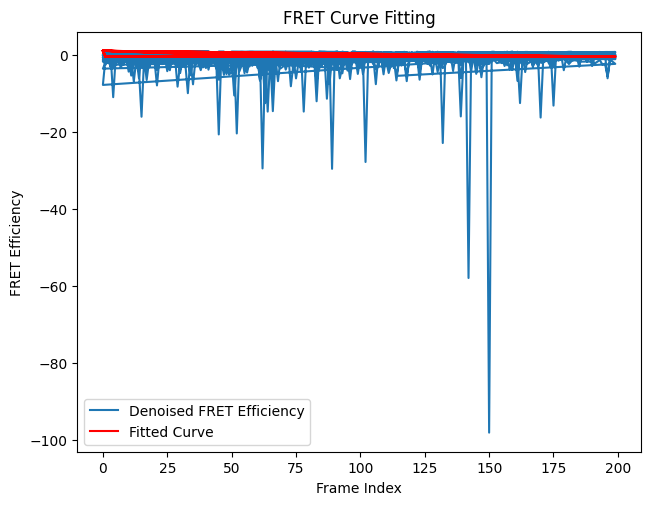

In [45]:

# Curve Fitting for FRET Analysis

# Curve fitting is the process of finding a curve that best fits the data points.
# It helps in modeling the relationship between variables and predicting future data points.

def fret_curve(x, E_fit, R0_fit):
    """
    Defines the FRET efficiency curve based on the distance (x),
    FRET efficiency (E_fit), and Förster distance (R0_fit).

    Parameters:
    x (array): The distance values (Frame index).
    E_fit (float): The FRET efficiency to fit.
    R0_fit (float): The Förster distance to fit.

    Returns:
    array: The fitted FRET efficiency values.
    """
    return 1 / (1 + (x / R0_fit)**6) * (1 - E_fit) + E_fit

# Perform Curve Fitting
# The curve_fit function is used to find the optimal parameters (E_fit and R0_fit) that make the fret_curve best fit the data.
params, _ = curve_fit(fret_curve, frame_index, denoised_fret_efficiency, p0=[0.5, 5])
fitted_E, fitted_R0 = params

# Advanced Visualization

# Visualization helps in understanding the results by displaying them in graphical form.

plt.figure(figsize=(16, 12))

# Plotting the denoised FRET efficiency and the fitted curve
plt.subplot(2, 2, 1)
# The plt.subplot(2, 2, 1) function divides the plotting area into a 2x2 grid (4 subplots total),
# with '1' indicating this is the first subplot (top-left corner).
plt.plot(frame_index, denoised_fret_efficiency, label='Denoised FRET Efficiency')
plt.plot(frame_index, fret_curve(frame_index, fitted_E, fitted_R0), color='red', label='Fitted Curve')
plt.xlabel('Frame Index')
plt.ylabel('FRET Efficiency')
plt.title('FRET Curve Fitting')
plt.legend()


Text(0.5, 1.0, 'Cross-Correlation between Donor and Acceptor')

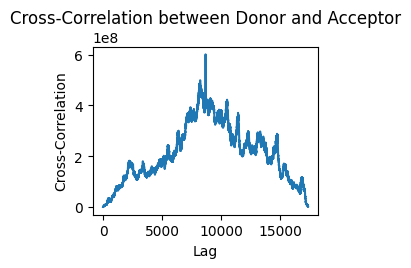

In [12]:

# Plotting the Cross-Correlation between Donor and Acceptor Channels

plt.subplot(2, 2, 2)
# The plt.subplot(2, 2, 2) function creates the second subplot in a 2x2 grid (positioned in the top-right corner).

# Plot the cross-correlation result
plt.plot(np.arange(len(cross_corr)), cross_corr, label='Cross-Correlation')
# np.arange(len(cross_corr)) generates an array of indices that correspond to the lag values in the cross-correlation.

# Labeling the axes
plt.xlabel('Lag')  # The x-axis represents the lag or shift between the donor and acceptor signals.
plt.ylabel('Cross-Correlation')  # The y-axis shows the degree of correlation at each lag value.

# Adding a title to the plot
plt.title('Cross-Correlation between Donor and Acceptor')

# Displaying the legend
plt.legend()




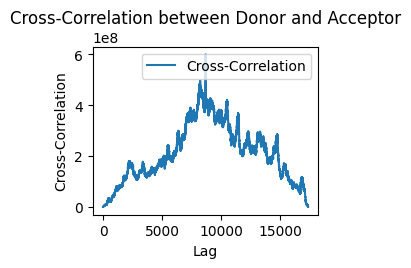

In [46]:
# Plotting the Cross-Correlation between Donor and Acceptor Channels

plt.subplot(2, 2, 2)
# The plt.subplot(2, 2, 2) function creates the second subplot in a 2x2 grid (positioned in the top-right corner).

# Plot the cross-correlation result
plt.plot(np.arange(len(cross_corr)), cross_corr, label='Cross-Correlation')
# np.arange(len(cross_corr)) generates an array of indices that correspond to the lag values in the cross-correlation.

# Labeling the axes
plt.xlabel('Lag')  # The x-axis represents the lag or shift between the donor and acceptor signals.
plt.ylabel('Cross-Correlation')  # The y-axis shows the degree of correlation at each lag value.

# Adding a title to the plot
plt.title('Cross-Correlation between Donor and Acceptor')

# Displaying the legend
plt.legend()



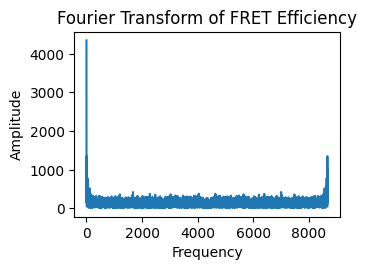

Fitted FRET Efficiency: -0.499
Fitted R0: -0.012
FRET analysis completed.


In [47]:
# Plotting the Fourier Transform of the denoised FRET efficiency

plt.subplot(2, 2, 4)
# The plt.subplot(2, 2, 4) function creates the fourth subplot in a 2x2 grid, positioned in the bottom-right corner.

# Plot the Fourier Transform result
plt.plot(np.arange(len(fft_fret_efficiency)), np.abs(fft_fret_efficiency), label='FFT')
"""
- `np.arange(len(fft_fret_efficiency))` generates a sequence of integers from 0 to the length of the fft_fret_efficiency array.
   - These integers represent discrete frequency bins, which correspond to the frequency components of the original signal.
   - Bins are discrete intervals that group frequencies, representing specific ranges in the plot.

- `np.abs(fft_fret_efficiency)` calculates the magnitude of the complex numbers from the Fourier-transformed data.
   - This magnitude indicates the amplitude of each frequency component, showing the strength of each frequency present in the original signal.
   - Plotting these magnitudes on the y-axis visualizes the signal's frequency content.
"""

# Labeling the axes
plt.xlabel('Frequency')  # The x-axis represents the frequency components of the signal.
plt.ylabel('Amplitude')  # The y-axis shows the amplitude or strength of each frequency component.

# Adding a title to the plot
plt.title('Fourier Transform of FRET Efficiency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as an image file
plt.savefig('advanced_fret_analysis.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Display fitted parameters
print(f"Fitted FRET Efficiency: {fitted_E:.3f}")
print(f"Fitted R0: {fitted_R0:.3f}")

# Completion Message
print("FRET analysis completed.")


In [58]:
# Check for any missing values or anomalies
print(data.describe())
print(data.info())


                ID  Frame index       Groups  Donor Photons  Acceptor Photons  \
count  8681.000000  8681.000000  8681.000000    8681.000000       8681.000000   
mean    960.722497    89.059671     1.708213     483.304764        100.156420   
std     917.916894    51.882112     0.486619     625.107785        148.227491   
min       0.000000     0.000000     1.000000       0.000000          0.000000   
25%     272.000000    46.000000     1.305610       0.000000          0.000000   
50%     619.000000    85.000000     1.714885     319.610000         64.491700   
75%    1545.000000   129.000000     2.000000     653.992000        124.589000   
max    3527.000000   199.000000     3.000000    5714.740000       1043.430000   

       FRET efficiency        X (nm)        Y (nm)  
count      8681.000000   8681.000000   8681.000000  
mean          0.140053  13739.982838  31031.844186  
std           0.198223  14951.250376  29321.265057  
min           0.000000      0.000000      0.000000  
25%  

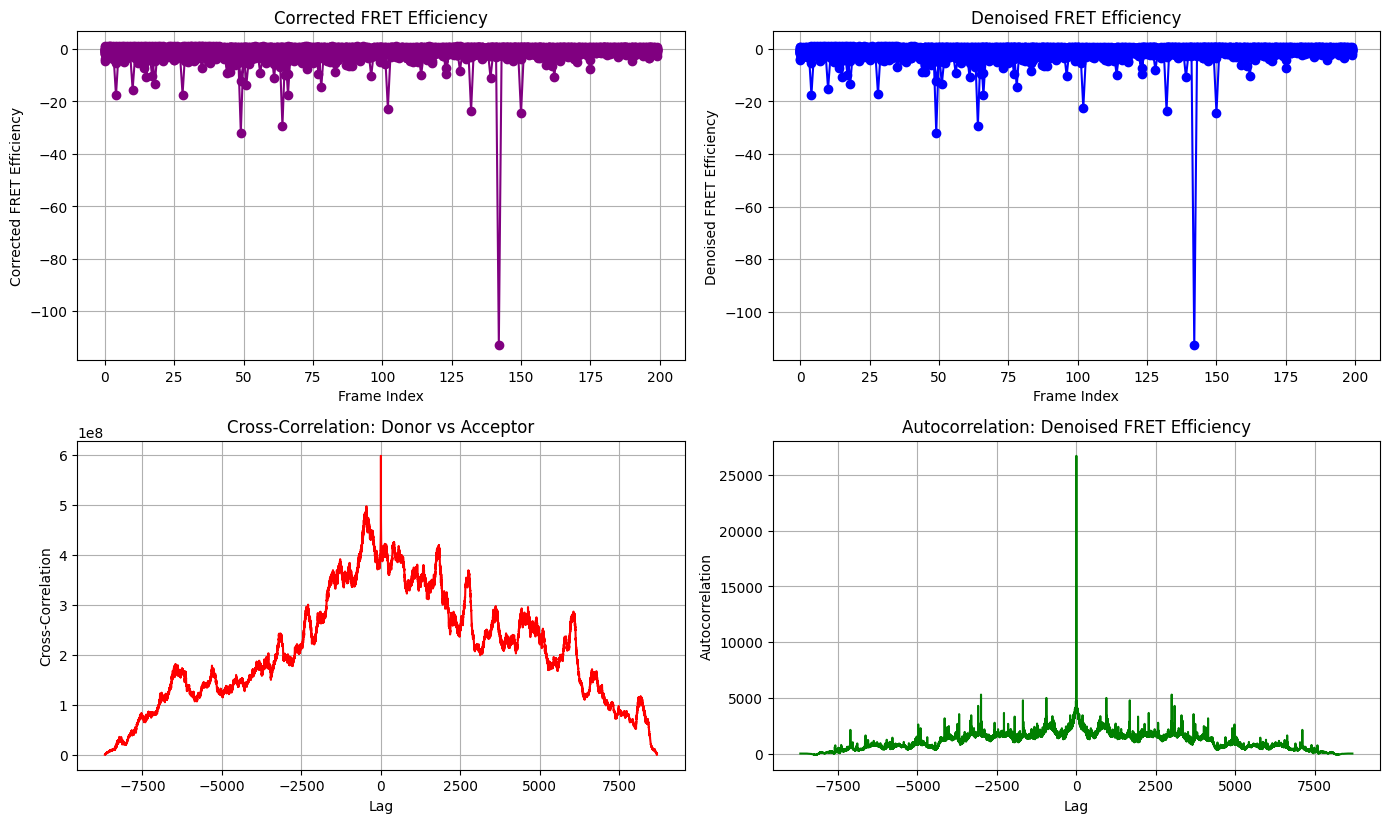

In [60]:


# Validate expected columns
expected_columns = ['Frame index', 'FRET efficiency', 'Donor Photons', 'Acceptor Photons']
if not all(col in data.columns for col in expected_columns):
    raise ValueError(f"Expected columns {expected_columns} not found in the data. Found columns: {data.columns.tolist()}")

# Extract necessary data columns into variables
frame_index = data['Frame index'].values
fret_efficiency = data['FRET efficiency'].values
donor_photons = data['Donor Photons'].values
acceptor_photons = data['Acceptor Photons'].values

# Define correction factors
alpha = 0.1  # Example value for alpha
delta = 0.05  # Example value for delta

# Simulate photon counts using Poisson distribution
simulated_donor_photons = np.random.poisson(donor_photons)
simulated_acceptor_photons = np.random.poisson(acceptor_photons).astype(float)  # Convert to float

# Avoid division by zero by replacing zeros with NaN in acceptor photons
simulated_acceptor_photons[simulated_acceptor_photons == 0] = np.nan

# Calculate the corrected FRET efficiency
corrected_fret_efficiency = fret_efficiency - (alpha * simulated_donor_photons / simulated_acceptor_photons) - delta

# Replace NaN values with zeros to avoid issues during correlation
corrected_fret_efficiency = np.nan_to_num(corrected_fret_efficiency, nan=0.0)

# Apply advanced noise reduction using wavelet denoising
denoised_fret_efficiency = denoise_wavelet(corrected_fret_efficiency, method='BayesShrink', mode='soft')

# Cross-correlation analysis between donor and acceptor channels
cross_corr = correlate(np.nan_to_num(simulated_donor_photons, nan=0), np.nan_to_num(simulated_acceptor_photons, nan=0), mode='full')

# Autocorrelation analysis for temporal dynamics
auto_corr = correlate(denoised_fret_efficiency, denoised_fret_efficiency, mode='full')

# Create plots to visualize the results
plt.figure(figsize=(14, 12))

# Plot corrected FRET efficiency
plt.subplot(3, 2, 1)
plt.plot(frame_index, corrected_fret_efficiency, marker='o', linestyle='-', color='purple')
plt.xlabel('Frame Index')
plt.ylabel('Corrected FRET Efficiency')
plt.title('Corrected FRET Efficiency')
plt.grid(True)

# Plot denoised FRET efficiency
plt.subplot(3, 2, 2)
plt.plot(frame_index, denoised_fret_efficiency, marker='o', linestyle='-', color='blue')
plt.xlabel('Frame Index')
plt.ylabel('Denoised FRET Efficiency')
plt.title('Denoised FRET Efficiency')
plt.grid(True)

# Plot cross-correlation
plt.subplot(3, 2, 3)
lags = np.arange(-len(cross_corr)//2 + 1, len(cross_corr)//2 + 1)
plt.plot(lags, cross_corr, color='red')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation: Donor vs Acceptor')
plt.grid(True)

# Plot autocorrelation
plt.subplot(3, 2, 4)
lags_auto = np.arange(-len(auto_corr)//2 + 1, len(auto_corr)//2 + 1)
plt.plot(lags_auto, auto_corr, color='green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation: Denoised FRET Efficiency')
plt.grid(True)

# Save and show the plots
plt.tight_layout()
plt.savefig('fret_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 8.641


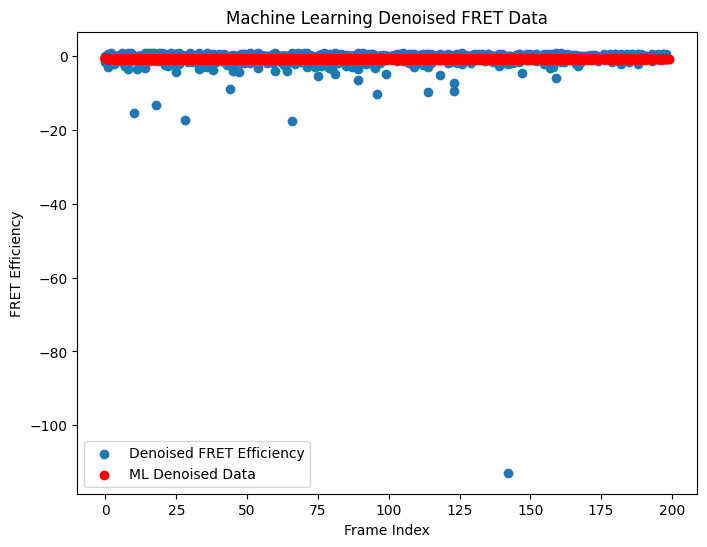

In [63]:
 #Machine Learning for further Denoising
# Machine learning models can be used to further clean the data by learning patterns and removing noise.
# Here we use a simple neural network model.

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(frame_index, denoised_fret_efficiency, test_size=0.2, random_state=42)

# Define a neural network model
model = Sequential()  # A Sequential model is a linear stack of layers.
model.add(Dense(units=16, activation='relu', input_dim=1))  # First layer with 16 units and ReLU activation
model.add(Dense(units=1, activation='linear'))  # Output layer with 1 unit and linear activation

# Compile the model
# The Adam optimizer is used to adjust the weights of the neural network.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict using the model
denoised_fret_ml = model.predict(X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, denoised_fret_ml)
print(f"Mean Squared Error: {mse:.3f}")

# Save Machine Learning Denoised Data Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label='Denoised FRET Efficiency')
plt.scatter(X_test, denoised_fret_ml, color='red', label='ML Denoised Data')
plt.xlabel('Frame Index')
plt.ylabel('FRET Efficiency')
plt.title('Machine Learning Denoised FRET Data')
plt.legend()
plt.savefig('ml_denoised_fret_data.png', dpi=300, bbox_inches='tight')
plt.show()